# Donacilla Cornea: Group Report

**Introduction**

“Donacilla cornea is a small (up to 20mm in length), burrowing intertidal bivalve found on shores of coarse, shelly or pebbly sand, in the Mediterranean and along the Atlantic coast of Europe” (Whiteley et al, 478). Donacillia corneas are soft-bodied marine animals. To explore these Donacilla corneas, we retrieved a dataset from the Institute of Marine Biology NAS Ukraine. We are intrigued by the recovery of Donacilla cornea populations on Ukrainian beaches as they are severely affected by a population bottleneck—a sharp reduction in the size of a population due to environmental events.

The dataset we will be working with includes data manually collected from four locations, each with samples from their “swash zone” (high population density) by using a square sampling frame (10 cm^2) to the depth of 20 cm.

<br>

The four different locations are:

1. Gravel spit of Lake Sasyk-Sivash in the vicinity of Evpatoria city (Crimean peninsula) (153 specimens) 19.05.2013; <br>
2. Southern shore of Dzharylgach Island (Kherson region) with medium-grained sand (40 specimens) 20.08.2016; <br>
3. Beach on Budakskaya Spit (Odessa region) with medium-grained sand (107 specimens) 23–25.08.2017; <br>
4. Shore between villages Grigorovka and Chabanka (Odessa region) with medium-grained sand (35 specimens) 22.08.2019.






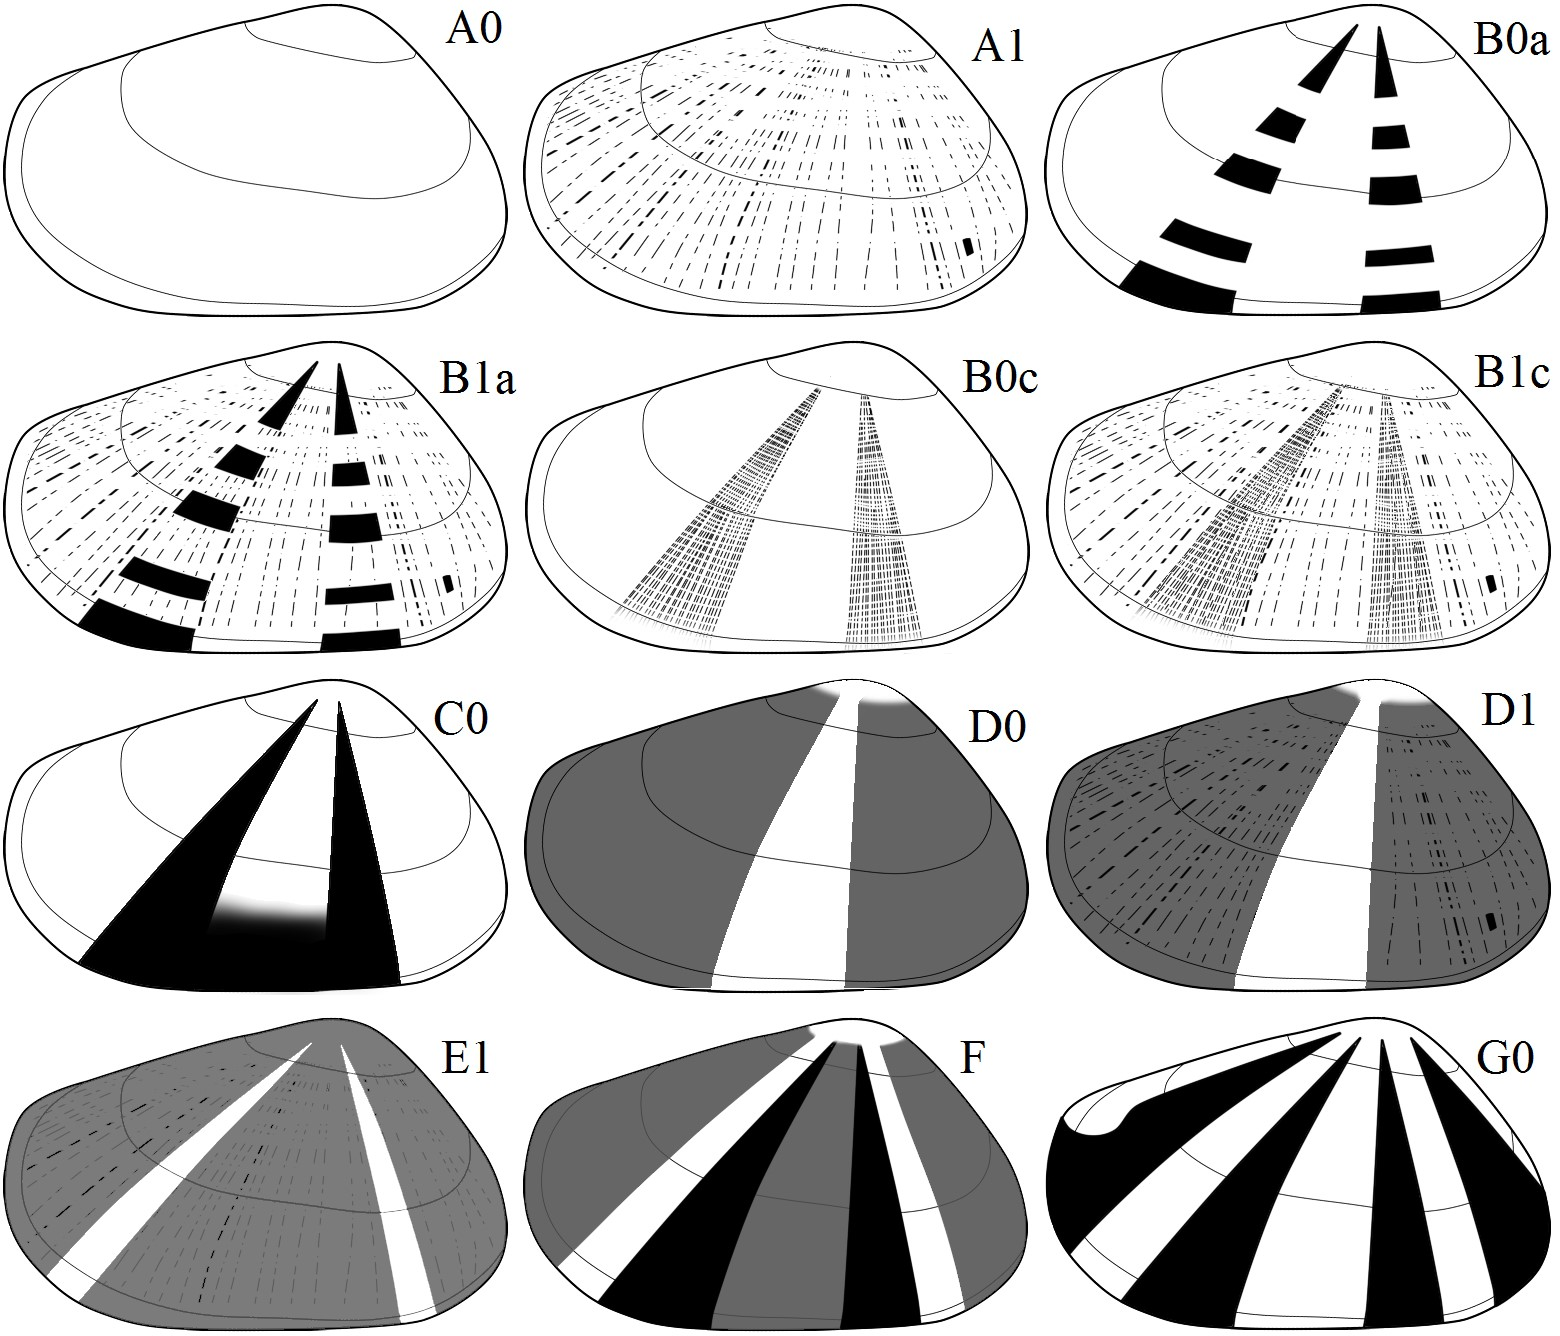






As notated above, total of 12 radial class patterns of Donacilla cornea shells can be found within the dataset. Our goal is to predict these radial class patterns of the affected Donacilla cornea populations, thus our predictive question is:

**How do we predict the radial class pattern of Donacilla cornea using only the length, width, and height?**

**Method**
1. Tidy our dataset: R
2. Use the k-nearest-neighbors classification model by splitting our data proportionally (0.75 and 0.25) to a training and testing subset respectively.
3. Visualize each of the predictor variables for the training data with histograms. 
4. Create a recipe and fix the issue of oversampling by making our classes count proportionally equal.
5. Create a workflow and tune the k-value to find the cross-validation accuracy to find which K-value has the best fit.
6. Make a new classification specification and workflow that uses the optimal k from the previous as the selected value of k. 
7. Visualize this data by using color-coded scatterplots. (We also used histograms to display the spread of data in our preliminary exploration.)
8. Record analysis and any other required information, giving concluding statements on the accuracy of our classification. 

**Expected Outcomes and Significance**

We hypothesize that a K-value around 3-6 would predict the radial class patterns most accurately—it’s not too large or small. We expect that length, width, and height will be reliable predictors of radial class pattern, ideally yielding a 75% accuracy. 

These findings could be utilized to further understand the qualities of Donacilla cornea shells and how their radial class patterns develop during their life cycle. 

Other possible questions to consider are:
1. Are the length, width, and height predictors effective/relevant?
2. Could we use the ratios as more reliable predictors instead? 
3. Are there other factors we should consider that’s outside of the dataset?

In [2]:
#this cell contains necessary libraries
install.packages("themis")
install.packages("kknn")
install.packages("GGally")
library(kknn)
library(themis)
library(tidyverse)
library(tidymodels)
library(repr)
library(GGally)

also installing the dependencies ‘RANN’, ‘ROSE’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

also installing the dependencies ‘labelled’, ‘broom.helpers’, ‘ggplot2’, ‘ggstats’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Loading required package: recipes

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘recipes’


The following object is masked from ‘package:stats’:

    step


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.4     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ stringr 1.5.0
✔ tidyr   1.3.0     ✔ forcats 0.5.2
✔ readr   2.1.3     
── Conflicts ─────────────────────────────────

Before starting our analysis, we will read the data into R and look at the original data to see what we're working with. 

In [4]:
#read the shell data from the web into r
url <- "https://raw.githubusercontent.com/rhe9598/dsci_group_project/main/Donacilla.csv"
shelldata <- read_csv(url)

#display first few rows of original data
head(shelldata)

Rows: 334 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): population, bg, rpclass, rpcolor, periostracum
dbl (6): l, w, h, w/l, h/l, w/h

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


population,l,w,h,w/l,h/l,w/h,bg,rpclass,rpcolor,periostracum
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
Budakskaya spit 2017,18.01,5.77,10.80,0.3204,0.5997,0.5343,white,A0,NA,absent
Budakskaya spit 2017,22.11,6.61,12.77,0.2990,0.5776,0.5176,white,A1,transparent,absent
Budakskaya spit 2017,19.36,6.09,12.02,0.3146,0.6209,0.5067,white,A1,grey,absent
Budakskaya spit 2017,19.76,6.46,12.04,0.3269,0.6093,0.5365,gray&purple,A1,black,absent
Budakskaya spit 2017,19.56,5.62,11.63,0.2873,0.5946,0.4832,white,A0,NA,partial
Budakskaya spit 2017,22.88,7.44,14.39,0.3252,0.6289,0.5170,gray,A0,NA,absent


**Step 1:** We have columns in this data set that aren't useful in our data analysis. We will tidy and wrangle our data by removing the classes with low counts and obtaining our predictors

In [5]:
#remove columns that will not be used in our analysis
shellselectdata <- shelldata |>
select(l,w,h,rpclass)

#create a vector for the three classes
classes <- c("A0", "A1" , "B0a")

#filter the data using the values in the vector, transformed rpclass into a factor
shellfilterdata <- shellselectdata |>
                    filter(rpclass %in% classes) |>
                    mutate(rpclass = as_factor(rpclass))

#display first few rows of filtered data only for tidiness
head(shellfilterdata)

l,w,h,rpclass
<dbl>,<dbl>,<dbl>,<fct>
18.01,5.77,10.80,A0
22.11,6.61,12.77,A1
19.36,6.09,12.02,A1
19.76,6.46,12.04,A1
19.56,5.62,11.63,A0
22.88,7.44,14.39,A0


The reason we chose length, width, and height as our predictors is because we wanted to see if it was possible to use size of a shell as a way to predict its radial pattern class. We removed the columns besides the rpclass, length, width, and height columns because our goal is to use the individual parameters of length, width, and height as our predictors. Therefore, the other columns are irrelevant to our analysis. 

**Step 2:** We will now split our data proportionally (0.75 and 0.25) to a training and testing subset respectively.

In [7]:
#split the data into testing and training
set.seed(9999)

shell_split <- initial_split(shellfilterdata, prop = 0.75, strata = rpclass)
training_data <- training(shell_split)
testing_data <- testing(shell_split) 

We will then set up data for the primary visualizations for our l, w, and h predictor variables using the training data.

In [8]:
#table that shows the counts of each of the classes
class_count <- training_data |>
    group_by(rpclass) |>
    summarize(count = n())
class_count

rpclass,count
<fct>,<int>
A0,135
A1,48
B0a,27


In [9]:
#table that shows the means of each of the predictor variables
predictor_means <- training_data |>
    select(l, w, h) |>
    map_df(mean)

predictor_means

#table that shows the means of each predictor variable grouped by rpclass
rpclass_predictor_means <- training_data |>
    group_by(rpclass) |>
    summarize(mean_length = mean(l), mean_width = mean(w), mean_height = mean(h))

rpclass_predictor_means

l,w,h
<dbl>,<dbl>,<dbl>
17.6979,5.797667,10.84905


rpclass,mean_length,mean_width,mean_height
<fct>,<dbl>,<dbl>,<dbl>
A0,17.61859,5.791037,10.84133
A1,17.18208,5.538958,10.45417
B0a,19.01148,6.290741,11.58963


**Step 3:** We will now visualize our training data for each of the predictors (l, w, h).

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


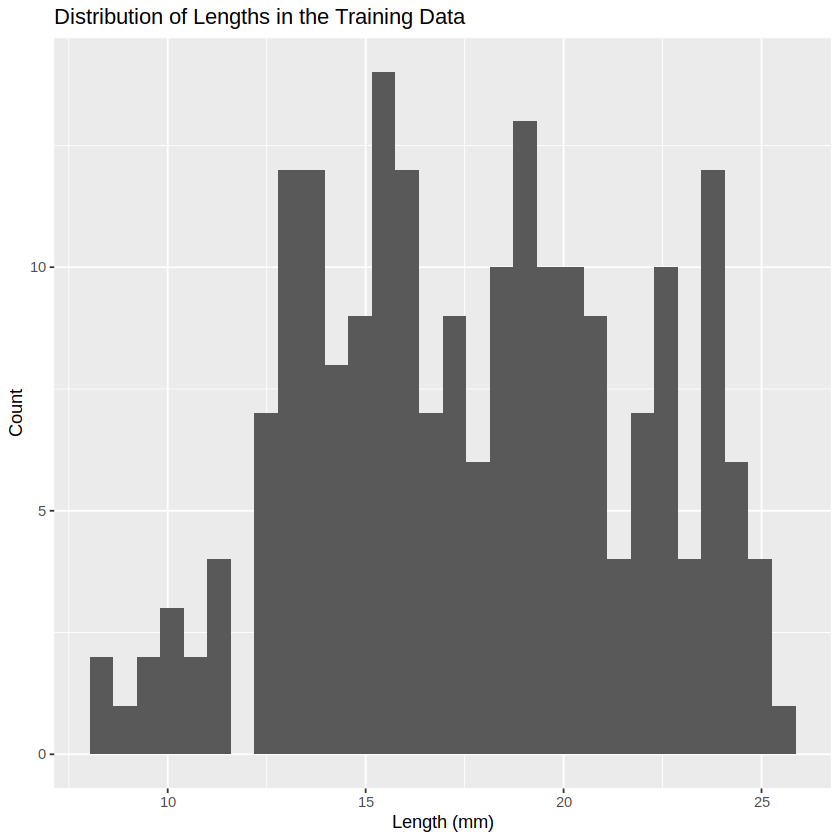

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


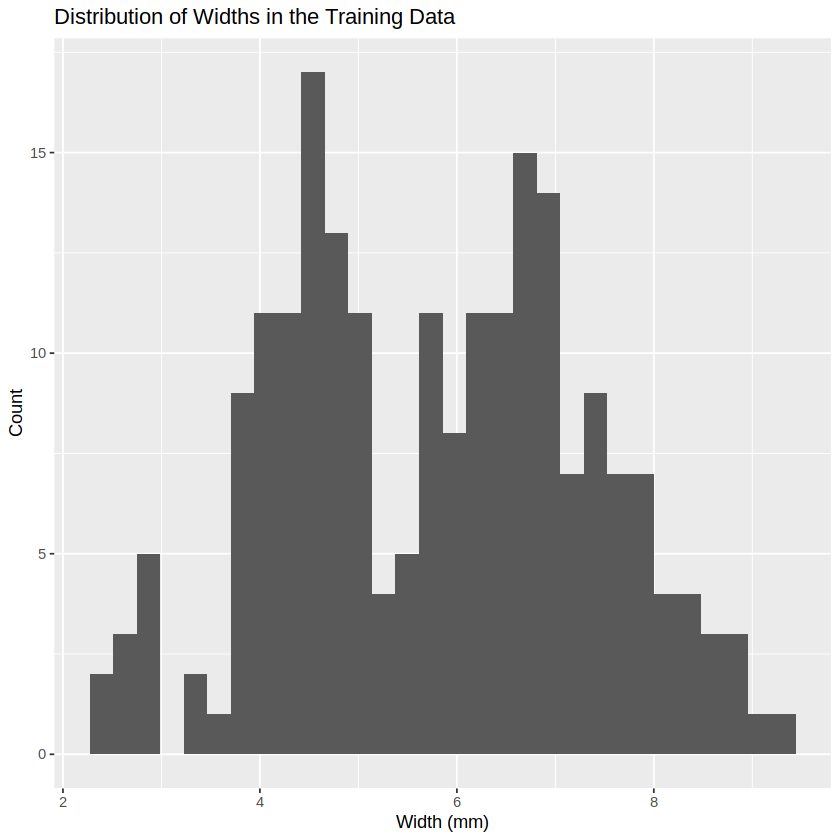

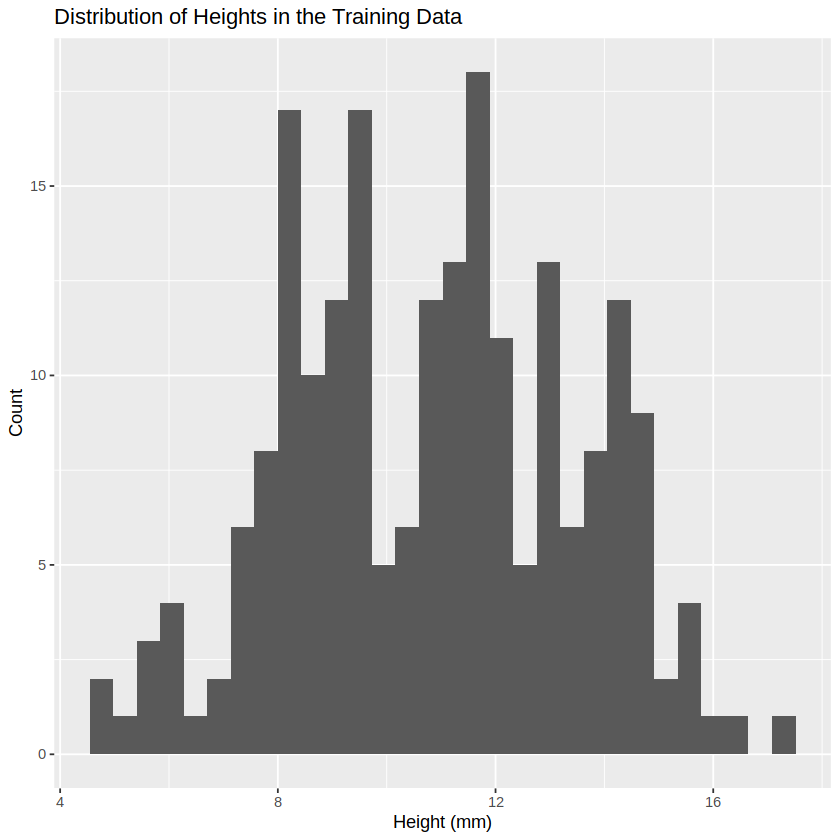

In [11]:
#histogram of the distribution of length
length_distribution <- training_data |>
ggplot(aes(x = l)) +
geom_histogram() +
labs(x = "Length (mm)", y = "Count") +
ggtitle("Distribution of Lengths in the Training Data")

#histogram of the distribution of width
width_distribution <- training_data |>
ggplot(aes(x = w)) +
geom_histogram() +
labs(x = "Width (mm)", y = "Count") +
ggtitle("Distribution of Widths in the Training Data")

#histogram of the distribution of height
height_distribution <- training_data |>
ggplot(aes(x = h)) +
geom_histogram() + 
labs(x = "Height (mm)", y = "Count") +
ggtitle("Distribution of Heights in the Training Data")

length_distribution
width_distribution
height_distribution

All three distributions above are multimodal with multiple peaks and shorter tails. The distributions for length and height have the largest spread, both having ranges of around 18.5 and 14 respectively, and the distribution for width having a range of around 5. 

**Step 4:** We will now create a recipe for our classification model and use the `prep` and `bake` functions to preprocess our data and scale and center all of our predictors.  

In [17]:
set.seed(9999) 

#create model for tuning
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
      set_engine("kknn") |>
      set_mode("classification")

#create recipe using predictors length, width, and height
shell_recipe <- recipe(rpclass ~ l + w + h, data = training_data) |>
                       step_scale(all_predictors()) |>
                       step_center(all_predictors())


#fix oversampling issue by using the step_upsample function
upsampled_data <- step_upsample(shell_recipe, rpclass, over_ratio = 1, skip = FALSE) |>
prep()

upsampled_data

shell_upsampled <- bake(upsampled_data, training_data)

shell_upsampled <- shell_upsampled |>
                group_by(rpclass) |>
                summarize(n = n())

shell_upsampled

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          3

Training data contained 210 data points and no missing data.

Operations:

Scaling for l, w, h [trained]
Centering for l, w, h [trained]
Up-sampling based on rpclass [trained]

rpclass,n
<fct>,<int>
A0,135
A1,135
B0a,135


By setting skip = FALSE in the step_upsample function, there are data points that are duplicates in the testing and validation sets. To explain, since tidymodels splits the data into the testing and validation sets for us, it can not process the duplicates because they indicate that information from our training sets has bled into our validation set. If skip was set to TRUE, it would ignore these duplicates. However, by setting it to FALSE we force it run with the duplicates present, resulting in inflated validation accuracies.

**Step 5:** Now, we will split the data into training and validation sets and create a workflow with a tuned k value. This will allow us to assess the accuracy of various values for k, and pick the one with the highest accuracy.  

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,multiclass,0.4850336,5,0.03714110,Preprocessor1_Model01
2,roc_auc,hand_till,0.4832202,5,0.01977171,Preprocessor1_Model01
3,accuracy,multiclass,0.5524134,5,0.02736828,Preprocessor1_Model02
3,roc_auc,hand_till,0.4791358,5,0.01461845,Preprocessor1_Model02
4,accuracy,multiclass,0.5815547,5,0.01687319,Preprocessor1_Model03
4,roc_auc,hand_till,0.4848573,5,0.02002641,Preprocessor1_Model03


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,multiclass,0.4850336,5,0.03714110,Preprocessor1_Model01
3,accuracy,multiclass,0.5524134,5,0.02736828,Preprocessor1_Model02
4,accuracy,multiclass,0.5815547,5,0.01687319,Preprocessor1_Model03
5,accuracy,multiclass,0.5915377,5,0.03117979,Preprocessor1_Model04
6,accuracy,multiclass,0.6103692,5,0.02838691,Preprocessor1_Model05
7,accuracy,multiclass,0.5913162,5,0.02719420,Preprocessor1_Model06


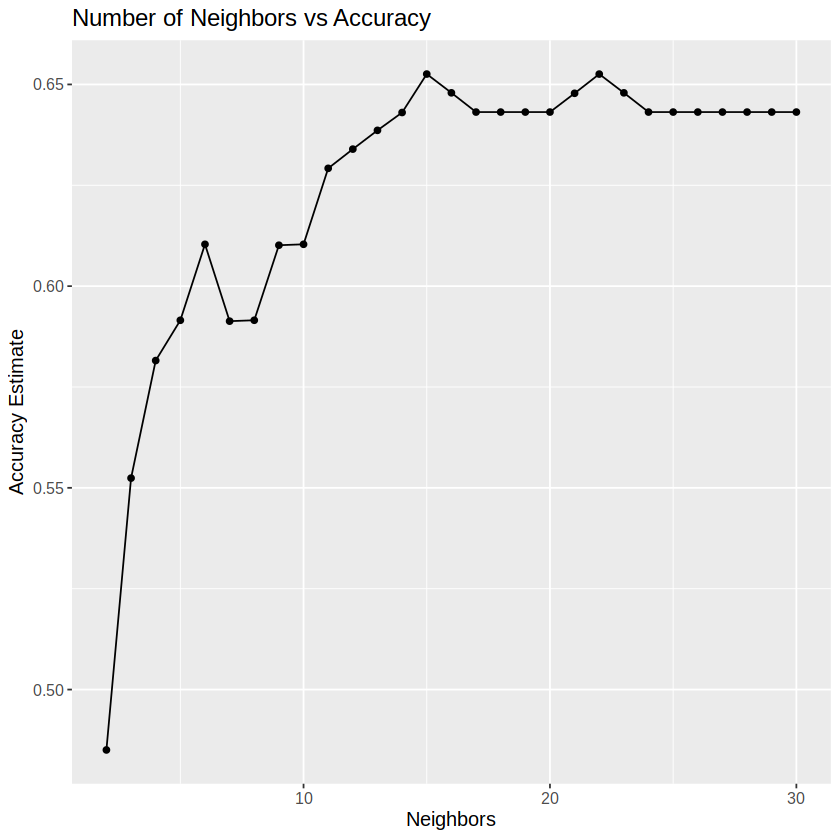

In [18]:
set.seed(9999)
#split data into training and validation sets
vfold <- vfold_cv(training_data, v = 5, strata = rpclass)

#create a tibble that contains different values of k to test 
k_vals <- tibble(neighbors = seq(from = 2, to = 30, by = 1))

#create a workflow 
knn_results <- workflow() |>
  add_recipe(shell_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = vfold, grid = k_vals) |>
  collect_metrics() 
head(knn_results)

#filter for accuracy metrics
accuracies <- knn_results |>
  filter(.metric == "accuracy")
head(accuracies)

#create a plot that shows the accuracy corresponding to each k value
cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12)) +
    ggtitle("Number of Neighbors vs Accuracy")
cross_val_plot


Based on our cross validation plot above, we can see that the highest accuracy occurs when the number of neighbors is 15. We will use k = 15.

**Step 6:** We will now re-create the specification with the optimal k = 15 from the previous step as the number of neighbours. This will allow us to make a new workflow and evaluate the model's accuracy by running the classification on the testing set. 

In [23]:
#create a new model with the best number of neighbors found in the plot/table above
knn_spec_new <- nearest_neighbor(weight_func = "rectangular", neighbors = 15) |>
      set_engine("kknn") |>
      set_mode("classification")

#create a new workflow with the new model, fitted to the training data to train the model
knn_fit <- workflow() |>
    add_recipe(shell_recipe) |>
    add_model(knn_spec_new) |>
    fit(data = training_data) 
knn_fit

#apply the trained model to the testing data
test_predictions <- predict(knn_fit, testing_data) |>
    bind_cols(testing_data)
head(test_predictions)

#report the model's accuracy
test_prediction_accuracy <- test_predictions |>
    metrics(truth = rpclass, estimate = .pred_class)
test_prediction_accuracy

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(15,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.3619048
Best kernel: rectangular
Best k: 15

.pred_class,l,w,h,rpclass
<fct>,<dbl>,<dbl>,<dbl>,<fct>
A0,19.36,6.09,12.02,A1
A0,19.83,6.40,12.07,B0a
A0,20.99,7.01,13.68,A0
A0,20.00,5.91,11.68,A1
A0,22.88,7.41,14.38,B0a
A0,20.57,6.96,13.47,A0


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.61111111
kap,multiclass,-0.01204819


The accuracy of 0.6111 in our model's predictions indicates that the model correctly predicts the class of the data points in our test data set about 61.11% of the time. To further understand this number in the context of our model, we will create a confusion matrix which shows the table of predicted labels and correct labels.

In [24]:
dornea_mat <- test_predictions |>
             conf_mat(truth = rpclass, estimate = .pred_class)

dornea_mat

          Truth
Prediction A0 A1 B0a
       A0  43 15  10
       A1   3  1   0
       B0a  0  0   0

We can see from the confusion matrix above that 43 predictions for A0, 1 prediction for A1, and 0 predictions for B0a were correct. The model was the best at predicting A0 and inadequate at correctly predicting A1 and B0a. This suggests that there were issues with model specificity or class imbalance.

**Step 7:** We will now make 2 visualizations that represent our analysis and predictions. The first visualization will show the correlations between each of the predictor variables from the training data, colored by class. The second visualization will show the correlations between each of the predictor variables for each of our predictions, colored by class.

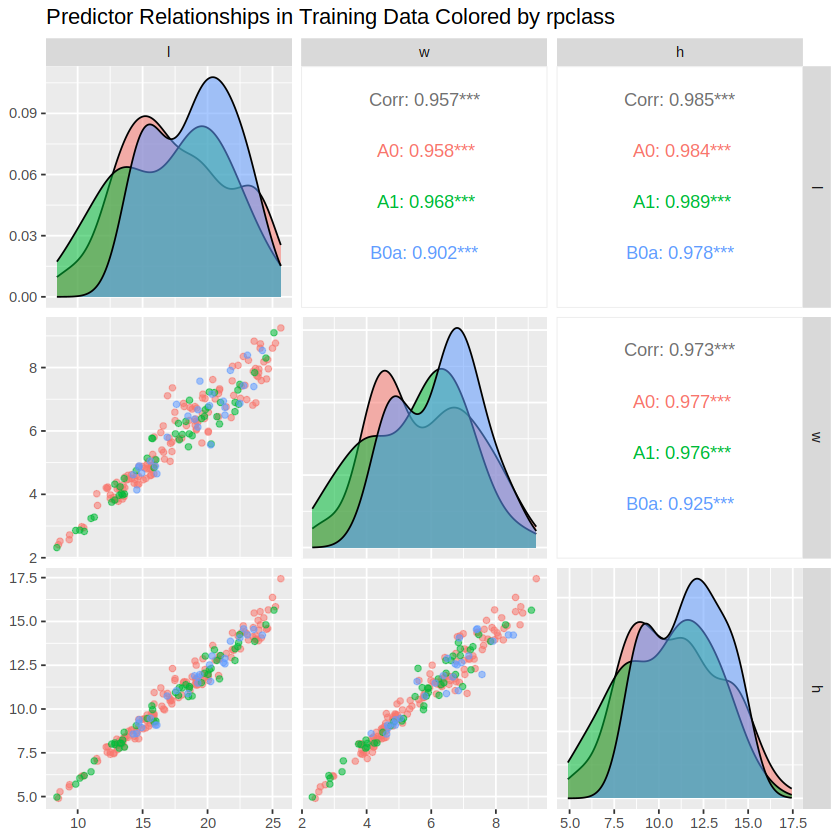

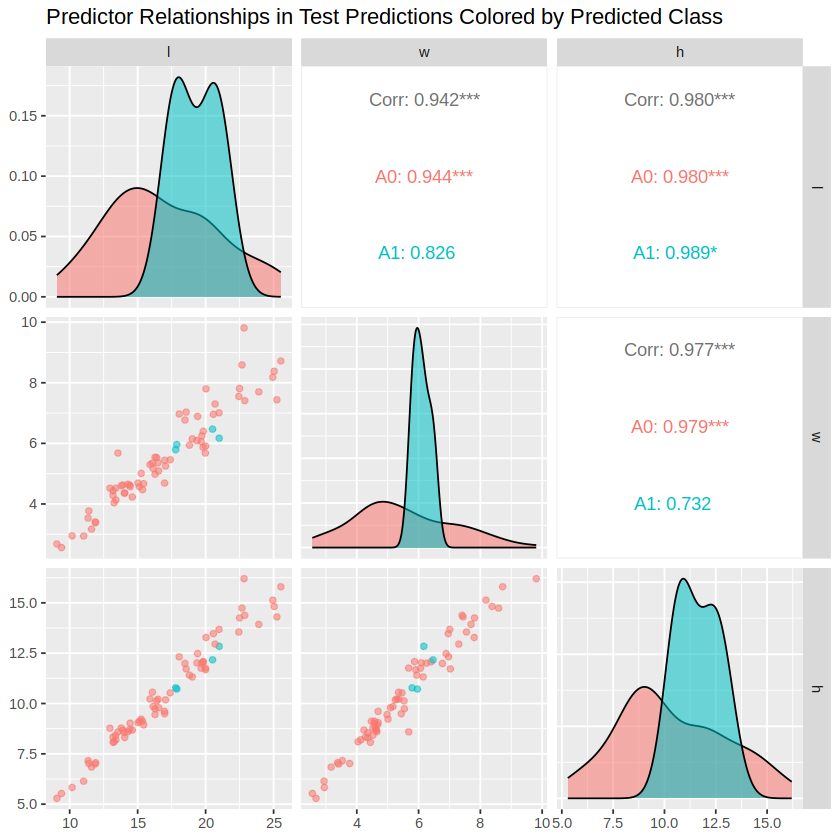

In [39]:
#ggpairs plot of original data, color coded by class
dornea_pairs_original_plot <- training_data |>
                        select(l:h) |>
                        ggpairs(aes(color = training_data$rpclass, alpha = 0.05),
                                title = "Predictor Relationships in Training Data Colored by rpclass")

dornea_pairs_original_plot

#ggpairs plot of new observation, color coded by predicted class
dornea_pairs_predictions_plot <- test_predictions |>
                        select(l:h) |>
                        ggpairs(aes(color = test_predictions$.pred_class, alpha = 0.05),
                                title = "Predictor Relationships in Test Predictions Colored by Predicted Class")

dornea_pairs_predictions_plot

The above visualizations confirm that the majority of the predictions were A0, and there are no predictions for B0a. 

**Step 8**: Conclusion and Final Remarks



**References List**

(Creative Commons — Attribution-NonCommercial-ShareAlike 4.0 International — CC BY-NC-SA 4.0, n.d.; Whiteley et al., 1997)

Whiteley, D., Owen, D. F., & David. (1997). Massive polymorphism and natural selection in Donacilla cornea (Poli, 1791) (Bivalvia: Mesodesmatidae). Biological Journal of the Linnean Society, 62(4), 475–494. https://doi.org/10.1111/j.1095-8312.1997.tb00316.x